<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [3]:
# Import some necessary modules
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import time
import scipy as sp
import pickle
%load_ext autoreload
%autoreload 2

In [4]:
# Import MuSiCal
import musical

# Overview 

In this notebook, we outline all the steps in a full pipeline of mutational signature analysis with MuSiCal, except preprocessing. 

# Input data

The input mutation count matrix $X$ should be of size (n_features, n_samples), where, for example, n_features = 96 for SBS signatures.

Here we use a simulated dataset based on PCAWG breast cancers as an example. The dataset contains 8 SBS signatures (SBS1, 2, 3, 5, 8, 13, 17b, and 18). Note that some minor signatures in the original PCAWG breast cancer dataset are removed for simplicity. You can replace `X` with your own dataset. 

In [5]:
X = pd.read_csv('./data/simulated/data_simul.pcawg_breast_8sig.X.csv', index_col=0)

In [20]:
X.head()

,SP117956,SP117402,SP117378,SP117244,SP117079,SP117312,SP117108,SP117370,SP117850,SP117593,...,SP7291,SP7171,SP10563,SP12186,SP10944,SP6673,SP118012,SP124199,SP116365,SP2159
Type,,,,,,,,,,,,,,,,,,,,,
A[C>A]A,20,25,18,13,17,22,36,21,15,13,...,51,55,52,60,100,389,21,32,78,14
A[C>A]C,13,23,19,9,12,13,16,18,6,8,...,34,21,31,28,86,324,13,27,65,20
A[C>A]G,5,6,4,2,1,1,2,2,0,2,...,5,5,5,7,10,35,4,2,5,5
A[C>A]T,17,13,8,11,5,9,26,10,7,8,...,22,24,22,36,67,312,14,17,41,7
C[C>A]A,14,19,17,17,5,8,52,22,5,6,...,54,55,45,77,110,317,26,28,76,22


# *De novo* signature discovery 

*De novo* signature discovery can be performed with `musical.DenovoSig`. An example code is as follows:
```
model = musical.DenovoSig(X, 
                          min_n_components=1, # Minimum number of signatures to test
                          max_n_components=10, # Maximum number of signatures to test
                          init='random', # Initialization method
                          method='mvnmf', # mvnmf or nmf
                          n_replicates=20, # Number of mvnmf/nmf replicates to run per n_components
                          ncpu=10, # Number of CPUs to use
                          max_iter=100000, # Maximum number of iterations for each mvnmf/nmf run
                          bootstrap=True, # Whether or not to bootstrap X for each run
                          tol=1e-8, # Tolerance for claiming convergence of mvnmf/nmf
                          verbose=1, # Verbosity of output
                          normalize_X=False # Whether or not to L1 normalize each sample in X before mvnmf/nmf
                         )
model.fit()
```

Note that the code above may take a while to finish. It is thus recommended to submit jobs to a cluster for the calculation. You can specify the number of CPUs to use through the `ncpu` parameter. Note that the same number of CPUs should be reserved via the job scheduler. For Slurm, `sbatch -n 10` should be used, for example, when `ncpu=10`. 

We have provided the output of `DenovoSig` on this dataset in the `./data/simulated` folder. Let's load it. The output is saved as a `pickle` file. To save an object using `pickle`, you can use
```
with open('/Output/path/and/filename.pkl', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)
```

In [7]:
with open('data/simulated/data_simul.pcawg_breast_8sig.DenovoSig_model.pkl', 'rb') as f:
    model = pickle.load(f)

We can inspect the plots for selecting the number of signatures. In this example, the correct number of signatures (n_components = 8) is selected. 

The left panel corresponds to the traditional method of selecting n_components by examining stability of solutions and the reconstruction errors. The middle panel displays the stability of each discovered signature. The right panel shows our preferred method for selecting n_components, i.e., by comparing n_components with the optimal number of clusters as determined by the gap statistic. Please see our paper for more details. 

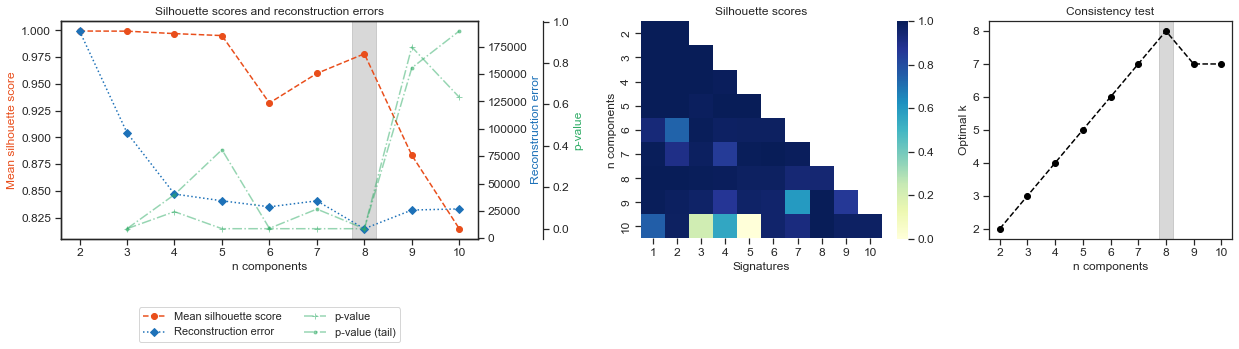

In [22]:
model.plot_selection()

The obtained *de novo* signatures can be visualized. 

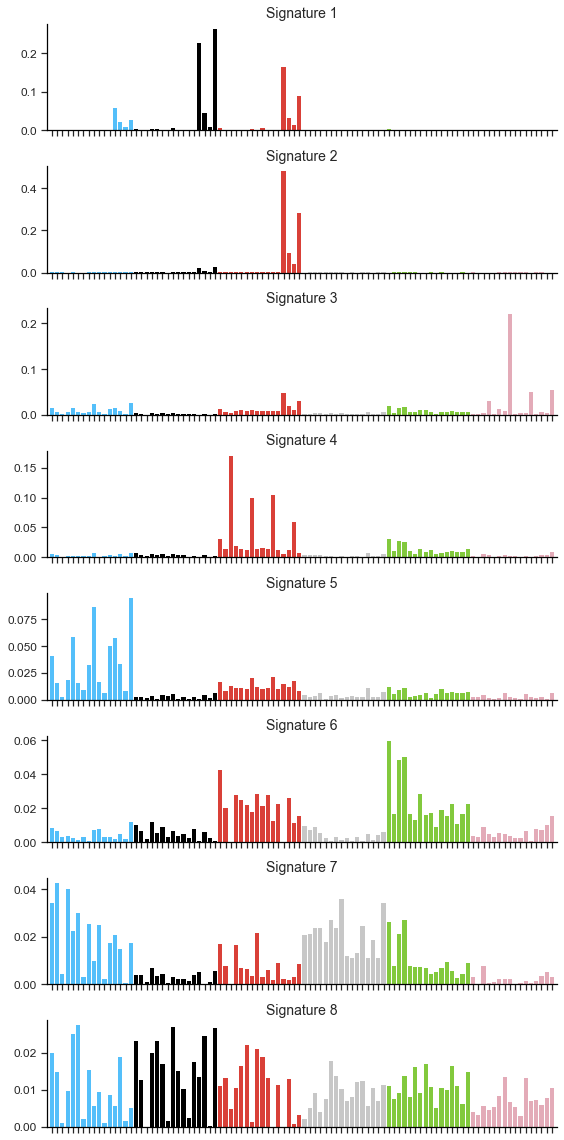

In [23]:
fig = musical.sigplot_bar(model.W)

# Matching and refitting

Define a grid for matching and refitting

In [8]:
model.thresh1 = np.logspace(-3, -1, 10, endpoint = True).tolist()
model.thresh1_match = np.logspace(-3, -1, 10, endpoint = True).tolist()

Load the catalog that will be used for refitting.
Restrict signatures to the specific tumor type.
Remove MMRD POLE-exo related signatures, if you have previously exclued these samples.

In [9]:
catalog = musical.load_catalog('COSMIC-MuSiCal_v3p2_SBS_WGS')

You can restrict catalog to the tumor type and based on MMRD POLE status as follows. PPD stands for polymerase proof-reading deficiency

In [10]:
catalog.restrict_catalog(tumor_type = 'Breast.AdenoCA', is_MMRD = False, is_PPD = False)

Get the signature matrix and signature names

In [11]:
W_catalog = np.array(catalog.W)
signatures = np.array(catalog.signatures)

Run refitting

In [ ]:
model.run_reassign(W_catalog = W_catalog, signatures = signatures)

# Validation

Run validation with a single command line (we suggest to perform this on a computing cluster because grid x 3 de novo discoveries are performed

In [ ]:
model.validate_assignment()

The above step is resource intensive so you can load the result saved in the data folder

In [13]:
with open('data/simulated/data_simul.pcawg_breast_8sig.DenovoSig_model.refit_validate.pkl', 'rb') as f:
    model = pickle.load(f)

The best refitting and matching parameters are selected based on the distance between signatures in simulations and data

In [15]:
print(model.thresh1)
print(model.thresh1_match)

[0.0025118864315095794]
[0.001]


Plot signatures discovered in simulated data. The de novo signatures for other grid parameters are saved in model.W_simul_all

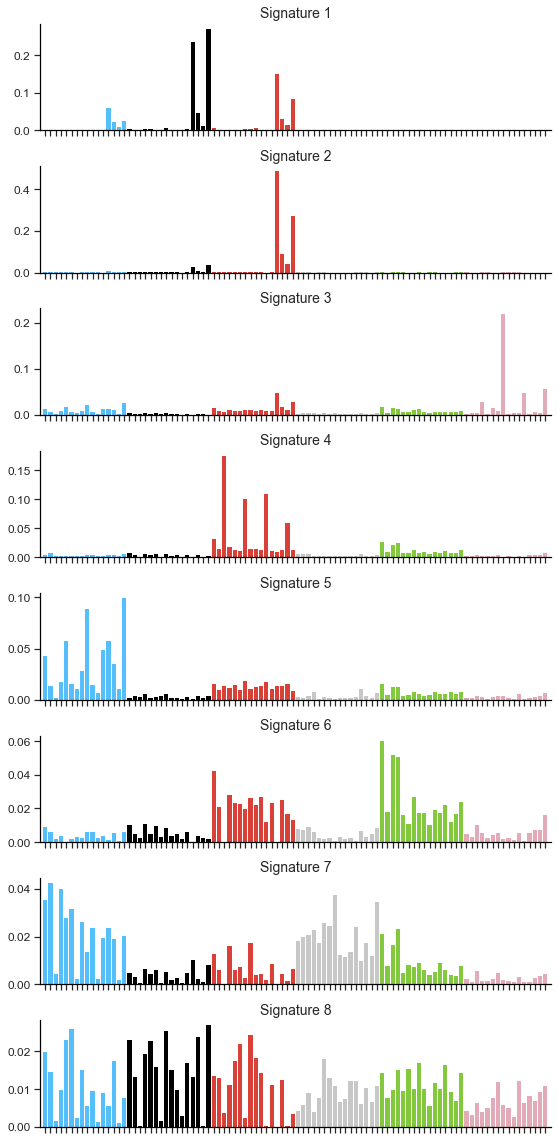

In [16]:
fig = musical.sigplot_bar(model.W_simul)

In [17]:
samples = X.columns

You can save the assignments as data tables:

In [18]:
W_s = model.W_s
H_s = model.H_s
df_W_s = pd.DataFrame(W_s, columns=model.signature_names, index=catalog.features)
df_H_s = pd.DataFrame(np.transpose(H_s), columns=model.signature_names, index=samples)
df_W_s.to_csv('W_s_example.csv')
df_H_s.to_csv('H_s_example.csv')

#### Alternative solution using distance between simulation and data with the largest discrepency

The best grid parameter is selected based on total cosine distance between W and W_simul, minimum number of signatures and smallest frobennius error in comparison of H and H_simul. It is also possible to use the cosine distance between W and W_simul for the signature with the largest discrepency. The grid index for this solution can be found and used to access the results

In [19]:
print(model.best_grid_index)
print(model.thresh1_all[model.best_grid_index])
print(model.thresh1_match_all[model.best_grid_index])

6
0.0025118864315095794
0.001


The signature assignments for all grid indices are saved in model.W_s_all and model.H_s_all. You can get the assignments corresponding to the above index:

In [20]:
W_s_alternative = model.W_s_all[model.best_grid_index]
H_s_alternative = model.H_s_all[model.best_grid_index]

# Comparing solution to the true exposures that were used to generate the input X matrix 

Download the input exposures and signatures

In [26]:
H_truth = pd.read_csv('data/simulated/data_simul.pcawg_breast_8sig.H_true.csv', index_col=0)
W_truth = pd.read_csv('data/simulated/data_simul.pcawg_breast_8sig.W_true.csv', index_col=0)
signatures_truth = np.array(W_truth.columns)
signatures_assigned = np.array(model.signature_names)
H_truth = np.array(H_truth)
W_truth = np.array(W_truth)

In [27]:
signatures_assigned

array(['SBS1', 'SBS2', 'SBS3', 'SBS5', 'SBS8', 'SBS13', 'SBS17b', 'SBS18'],
      dtype='<U6')

In [28]:
signatures_truth

array(['SBS1', 'SBS2', 'SBS3', 'SBS5', 'SBS8', 'SBS13', 'SBS17b', 'SBS18'],
      dtype=object)

Calculate sensitivity, false positive rate

In [29]:
inds = [index for index,item in enumerate(signatures_assigned) if item in signatures_truth]
inds_truth = [index for index,item in enumerate(signatures_truth) if item in signatures_assigned[inds]]

inds_unmatched = [index for index,item in enumerate(signatures_assigned) if item not in signatures_truth]
inds_truth_unmatched = [index for index,item in enumerate(signatures_truth) if item not in signatures_assigned]

per_sample_agreement = (H_s[inds,:] > 0) == (H_truth[inds_truth,:] > 0)

In [30]:
accuracy = np.sum(per_sample_agreement)/np.size(H_truth)

In [31]:
sensitivity = np.sum((H_truth[inds_truth] > 0) * per_sample_agreement)/np.sum(H_truth > 0) 
sensitivity = sensitivity - np.sum(H_truth[inds_truth_unmatched,:] > 0)/np.sum(H_truth > 0)

In [32]:
fpr = 1 - np.sum((H_truth == 0) * per_sample_agreement)/np.sum(H_truth == 0)
fpr = fpr + np.sum(H_s[inds_unmatched] > 0)/np.sum(H_truth == 0)